# Investigate indexes complexity

Le but de ce notebook est d'étudier la complexité des index et leur résultats dans vindex.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:

import numpy as np

from fast_vindex.utils import(generate_dask_datacube_from_indices)
from fast_vindex.dev.utils import (
    DaskArray2D
)

On commence par générer un dask_array 2D qui vas nous servir de référence pour réaliser les indexations. Sa particularité est que ses valeurs correspondent aux coordonnées de ses valeurs.

In [4]:
x = generate_dask_datacube_from_indices((9, 9) , (3, 3))

## Different Case

### 1) Simple square

In [8]:
indexes = (np.array([[1], [2], [3]]), np.array([[4, 5, 6]]))
display([idx.shape for idx in indexes])
x.vindex[indexes].compute()

[(3, 1), (1, 3)]

array([[(1, 4), (1, 5), (1, 6)],
       [(2, 4), (2, 5), (2, 6)],
       [(3, 4), (3, 5), (3, 6)]], dtype=object)

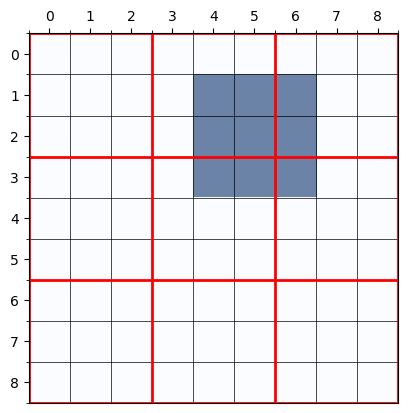

In [5]:
da2d = DaskArray2D(x)
da2d[indexes]

### 2) Double square

Nous avons essayer de trouver toutes les combinaisons de shape, pour identifier, les différents motifs qui existe. 

In [67]:
indexes = (np.array([1, 2, 3, 4, 5, 6]), np.array([4, 5, 6, 1, 2, 3]))

# Voici des exmples de shapes avec des motifs unique. 
reshapes = [
    ((6,), (6,)), # +
    ((3, 1, 2), (3, 2, 1)), # +
    ((2, 3, 1), (1, 3, 2)), # +
    ((2, 1, 3), (1, 2, 3)), # +
    ((2, 3, 1), (2, 1, 3)), # + celui qui nous intérèsse
    ((1, 2, 3), (3, 2, 1)), # +
    ((3, 1, 2), (1, 3, 2)), # +
]

# Voici des exemples de shapes qui correspondent à des motifs que l'ona  deja rencontré. 
reshapes_dbl = [
    ((1, 2, 3), (1, 2, 3)), # -
    ((2, 3, 1), (2, 3, 1)), # -
    ((3, 1, 2), (3, 1, 2)), # -
    ((3, 2, 1), (3, 1, 2)), # -
    ((2, 1, 3), (2, 3, 1)), # -
]

[(6,), (6,)]

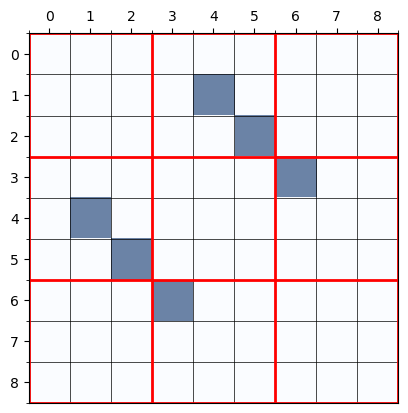

[(3, 1, 2), (3, 2, 1)]

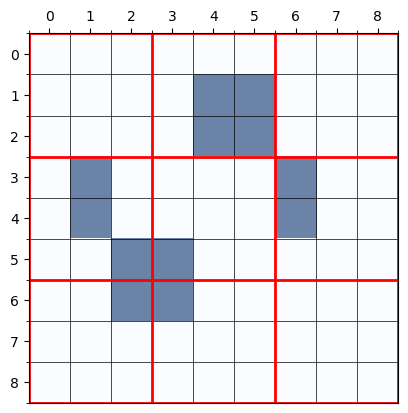

[(2, 3, 1), (1, 3, 2)]

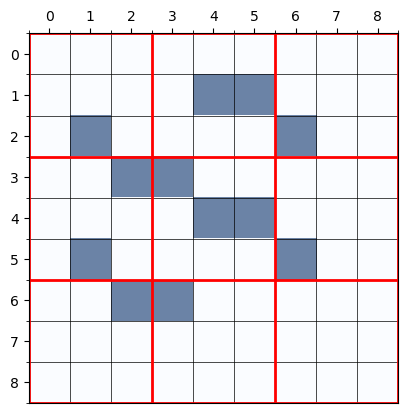

[(2, 1, 3), (1, 2, 3)]

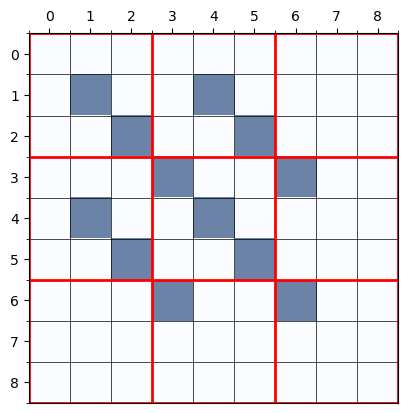

[(2, 3, 1), (2, 1, 3)]

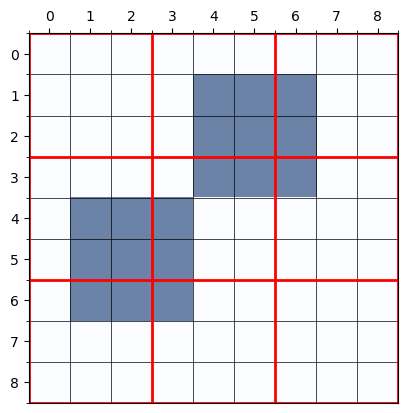

[(1, 2, 3), (3, 2, 1)]

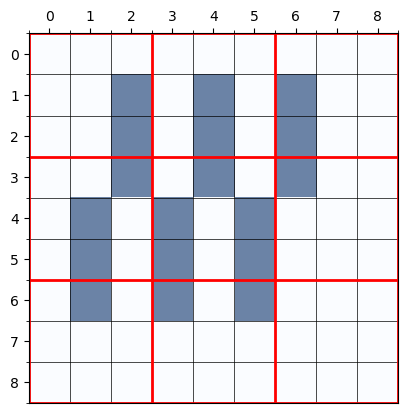

[(3, 1, 2), (1, 3, 2)]

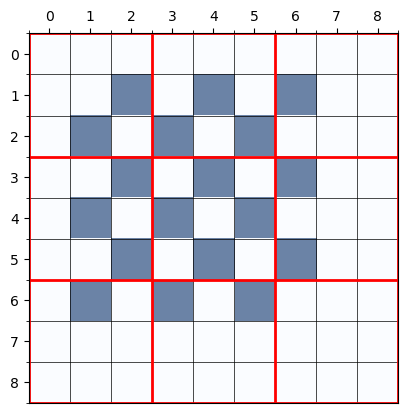

In [68]:
for (rshp1, rshp2) in reshapes:
    idx1, idx2 = indexes
    new_indexes = (idx1.reshape(rshp1), idx2.reshape(rshp2))
    x.vindex[new_indexes].compute()
    da2d = DaskArray2D(x)
    display([idx.shape for idx in new_indexes])
    da2d[new_indexes]

la difficultés est donc de réussir à sous découper ces motifs. Commençons par nous concentrer sur un motif.

### Special case for exemple 

In [69]:
indexes = (np.array([1, 2, 3, 4, 5, 6]).reshape((3, 1, 2)), np.array([4, 5, 6, 1, 2, 3]).reshape((3, 2, 1)))
x.vindex[indexes].compute()

array([[[(1, 4), (2, 4)],
        [(1, 5), (2, 5)]],

       [[(3, 6), (4, 6)],
        [(3, 1), (4, 1)]],

       [[(5, 2), (6, 2)],
        [(5, 3), (6, 3)]]], dtype=object)

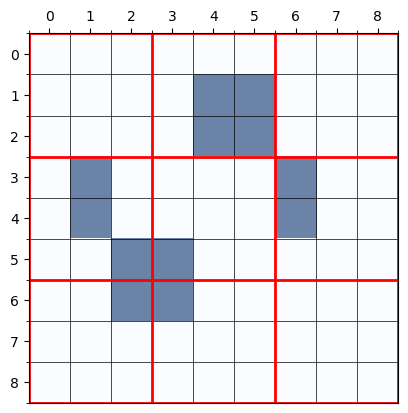

In [71]:
da2d = DaskArray2D(x)
da2d[indexes]

Ce motif est présent sur 6 chunks différents, il faudra donc le découper en 6 parties.

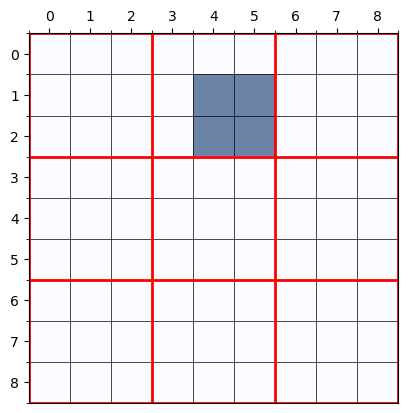

In [78]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[1, 2]]]),
    np.array([[[4],[5]]])
)]

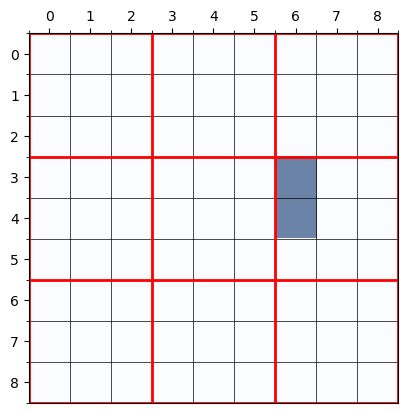

In [81]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[3, 4]]]),
    np.array([[[6]]])
)]

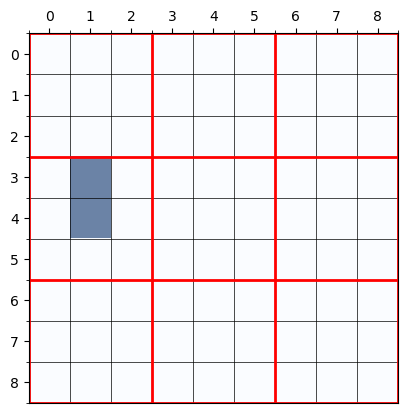

In [82]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[3, 4]]]),
    np.array([[[1]]])
)]

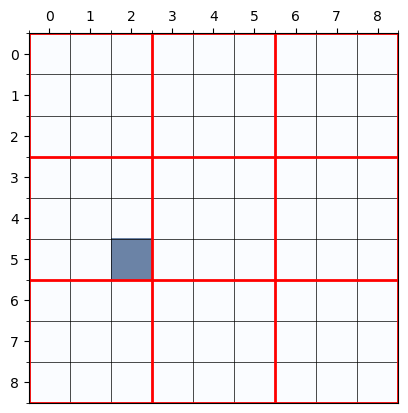

In [84]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[5]]]),
    np.array([[[2]]])
)]

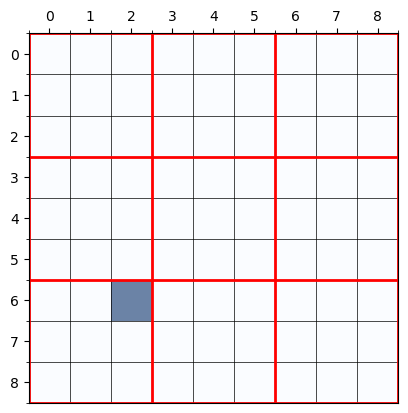

In [85]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[6]]]),
    np.array([[[2]]])
)]

In [73]:
indexes

(array([[[1, 2]],
 
        [[3, 4]],
 
        [[5, 6]]]),
 array([[[4],
         [5]],
 
        [[6],
         [1]],
 
        [[2],
         [3]]]))

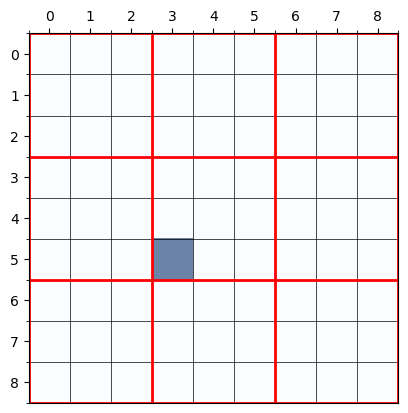

In [87]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[5]]]),
    np.array([[[3]]])
)]

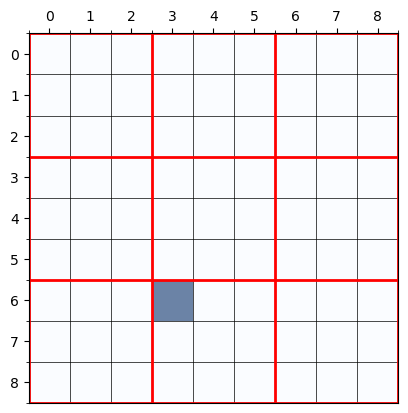

In [88]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[6]]]),
    np.array([[[3]]])
)]

On voit qu'il y a 2 parties, que l'on pourrait regrouper en 1 seul. Sauf que si l'on essaye de faire, ça, voici ce qui se passe.

In [93]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[3, 4]], [[5]]]),
    np.array([[[1]], [[2]]])
)]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1) + inhomogeneous part.

En effet, l'array de l'index 1, devient inhomogène. Ce qui pose de sérieux problème. Il faudrait faire celà, mais le sous-motif se retrouve sous 2 chunks

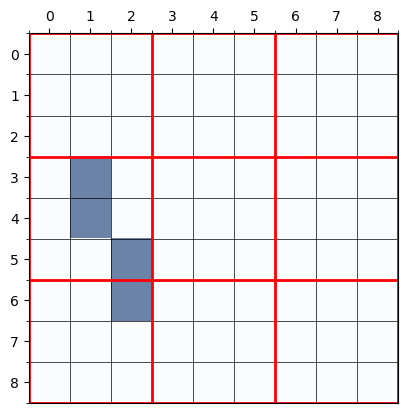

In [94]:
da2d = DaskArray2D(x)
da2d[(
    np.array([[[3, 4]], [[5, 6]]]),
    np.array([[[1]], [[2]]])
)]

L'idée que j'ai à ce niveau c'est à partir de inblocks_idxs et blocks_idxs, séparé les motis en sous-motifs, par chunks et ensuite, séparer les motifs inhomogène. 

On vois bien que celà relève d'une grande complexité. Pour l'instant je n'ai ni le temps, ni les compétences pour envisager d'améliorer cette partie. 

In [115]:
# Voici les inblock_idxs et blocks_idxs correspondant à cet index
inblock_idxs = [np.array([[[1, 2]], [[0, 1]], [[2, 0]]]), np.array([[[1], [2]], [[0], [1]], [[2], [0]]])]
block_idxs = [np.array([[[0, 0]], [[1, 1]], [[1, 2]]]), np.array([[[1], [1]], [[2], [0]], [[0], [1]]])]